# Convolutional Neural Networks

## Preliminaries

In this practical session you will implement and train several Convolutional Neural Networks (CNNs) using the Keras framework with a Tensorflow backend. If you are not already familiar with Keras, you can go over the [following tutorial](https://github.com/tueimage/essential-skills/blob/master/keras.md). More detailed information on the different functionalities can be found in the [Keras library documentation](https://keras.io/). 

Note that for this set of exercise CPU-only Tensorflow, which you should already have installed, is sufficient (i.e. GPU-support is not required but it will make your experiments run faster). 

You are also required to use the `gryds` package for data augmentation that you can install directly from git: `pip install git+https://github.com/tueimage/gryds/`.

You also have to install the Keras deep learning framework (if you have not done so already) by running `conda install keras`. Note that there are two implementations of Keras, one from https://keras.io/ and another one that ships with Tensorflow. Here we use the former. 

## MNIST
We will first train a simple CNN to classify handwritten digits using the MNIST dataset. This dataset is often referred to as the "Hello world!" example of deep learning because it can be used to quickly illustrate a small neural network in action (and obtain a decent classification accuracy in the process). More information on it can be found [here](http://yann.lecun.com/exdb/mnist/).

First, let's load the dataset and visualize some images.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# from keras datasets open mnist
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train_mnist = np.expand_dims(x_train, axis=-1)
x_test_mnist = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train_mnist = to_categorical(y_train, num_classes=10)
y_test_mnist = to_categorical(y_test, num_classes=10)

def plot_images(images, dim=(10, 10), figsize=(10, 10), title=''):
    
    plt.figure(figsize=figsize)
    
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plot_images(x_train_mnist[np.random.randint(0, x_train_mnist.shape[0], size=100)].reshape(100, 28, 28))

The MNIST classification task is quite simple: given an image, predict the digit that it contains. Thus, this is a 10-class classification problem.

Let's define a simple network for the handwritten digit classification.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Compile and train the network (note that this could take a while).

In [ ]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model.fit(x_train_mnist, y_train_mnist,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test_mnist, y_test_mnist))

score = model.evaluate(x_test_mnist, y_test_mnist, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Now that the model is trained, we can evaluate its performance on the independent test dataset.

In [ ]:
score = model.evaluate(x_test_mnist, y_test_mnist, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

## U-Net
The U-Net convolutional neural network architecture was first developed for biomedical image segmentation and is to this day one of the most widely used methods for image segmentation. The details of the architecture can be found in the [original paper](https://arxiv.org/abs/1505.04597). In this practical we will build and train a U-Net network that is able to segment blood vessels in retinal images. 

### Loading and visualizing the data
The data for this task is taken from the [DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/index.php) database. It consists of photographs of the retina, where the goal is to segment the blood vessels within. The dataset has a total of 40 photographs, divided in 20 images for training and 20 for testing. The images corresponding to the DRIVE test set can be found [here](https://www.dropbox.com/s/zk51wgupimw7jd9/DRIVE.zip?dl=0).

Let's load the training set and visualize an image with the corresponding blood vessel segmentation. For training we will divide the data in a training and a validation set to monitor the model during training.

Got 20 images, 20 masks, 20 segmentations
(20, 584, 565, 3)


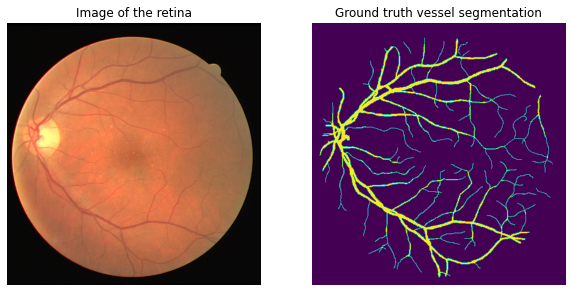

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

import os
import sys

sys.path.append('code/')
from unet_utils import load_data

# location of the DRIVE dataset
data_folder = '../practicals/data/week5/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

print(f'Got {len(images)} images, {len(masks)} masks, {len(segmentations)} segmentations')

# print the shape of image dataset
print(images.shape)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])

plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

### Training a U-Net model

You are already provided with implementation of the U-Net architecture in `unet_model.py`. This is a modular implementation and can be used to generate U-Net architectures with a variety of hyperparameters such as depth and number of feature maps. Before using the model, examine the code and documentation and make sure that you understand all the details.

We will train a U-Net model using smaller patches extracted from the training images. Training the images on smaller patches requires less computation power and results in a more varied training dataset (it has the effect of data augmentation by image translation). Because a U-Net is a fully convolutional network it can be evaluated on inputs of different size (the output size will change according to the input size). Thus, although the model will be trained on smaller patches it can still be used to segment larger images with one pass through the model. 


(16, 32, 32, 3)


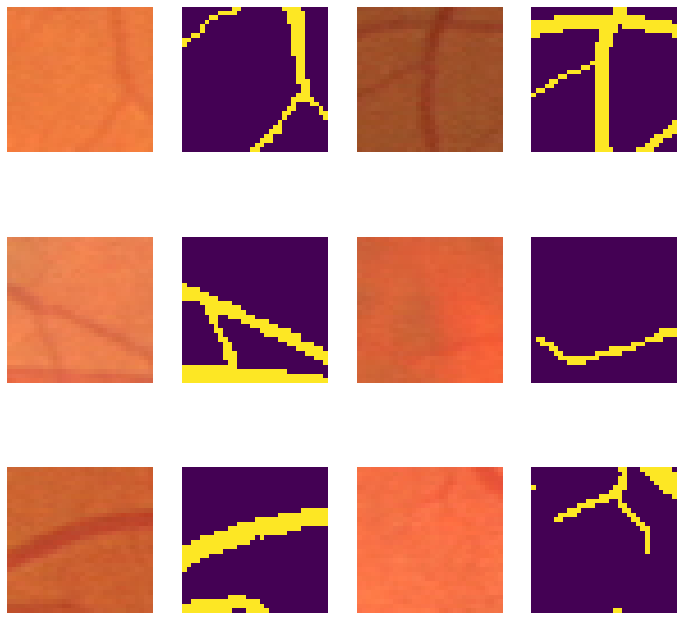

In [2]:
from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [5]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

# supress future warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Old shape: (4, 584, 584, 3)
New shape: (4, 584, 584, 3)


In [6]:
import os
from unet_model import unet
from unet_utils import datagenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 12
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
unet_model_orig = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# compile the model
unet_model_orig.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = unet_model_orig.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

(1, 584, 565, 3)
(1, 584, 565, 1)
Epoch 1/12
50/50 - 31s - loss: 0.4988 - acc: 0.8577 - val_loss: 0.4088 - val_acc: 0.9211
Epoch 2/12
50/50 - 27s - loss: 0.3027 - acc: 0.9506 - val_loss: 0.3912 - val_acc: 0.9147
Epoch 3/12
50/50 - 27s - loss: 0.2504 - acc: 0.9534 - val_loss: 0.2735 - val_acc: 0.9211
Epoch 4/12
50/50 - 27s - loss: 0.1845 - acc: 0.9587 - val_loss: 0.2867 - val_acc: 0.9200
Epoch 5/12
50/50 - 27s - loss: 0.2109 - acc: 0.9502 - val_loss: 0.3653 - val_acc: 0.9203
Epoch 6/12
50/50 - 27s - loss: 0.1673 - acc: 0.9556 - val_loss: 0.3263 - val_acc: 0.9218
Epoch 7/12
50/50 - 27s - loss: 0.1598 - acc: 0.9586 - val_loss: 0.2296 - val_acc: 0.9194
Epoch 8/12
50/50 - 27s - loss: 0.1416 - acc: 0.9596 - val_loss: 0.2640 - val_acc: 0.9266
Epoch 9/12
50/50 - 27s - loss: 0.1187 - acc: 0.9629 - val_loss: 0.3166 - val_acc: 0.9267
Epoch 10/12
50/50 - 27s - loss: 0.1241 - acc: 0.9600 - val_loss: 1.1887 - val_acc: 0.6014
Epoch 11/12
50/50 - 27s - loss: 0.1155 - acc: 0.9616 - val_loss: 0.2026 - v

### Visualizing the segmentation results

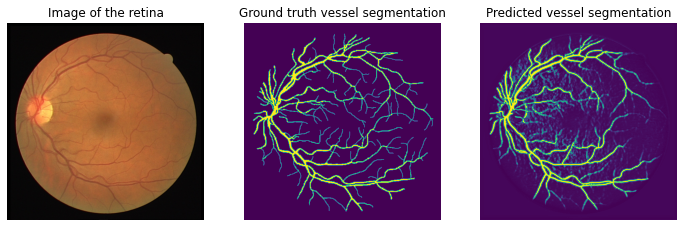

In [8]:
# run the model on one test image and show the results
from unet_utils import preprocessing

# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = unet_model_orig.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

# Exercises

## Number of parameters

The first convolutional layer in the MNIST example has 320 parameters. The first fully connected layer has 1179,776 parameters. What do these parameters correspond to? 

<font color='#770a0a'>What is the general expression for the number of parameters of 1) a convolutional layer and 2) a fully-connected layer?</font>

### Answer:

The parameters correspond to the weights and biases of the convolutional or fully connected layer.

1) Number of parameters of convolution layer:

$$
N_{conv} = R \cdot S \cdot C \cdot M + M
$$

Where $R$ is the height of the filter, $S$ is the width of the filter, $C$ is the number of input channels and $M$ is the number of filters.
Example of the first convolutional layer in the MNIST example: $R = 3$, $S = 3$, $C = 1$, $M = 32$. This gives:

$$
N_{conv} = 3 \cdot 3 \cdot 1 \cdot 32 + 32 = 320
$$

Which is correct. 

2) Number of parameters of fully connected layer:

$$
N_{fc} = N_{in} \cdot N_{out} + N_{out}
$$

Where $N_{in}$ is the number of input neurons and $N_{out}$ is the number of output neurons.
Example of the first fully connected layer in the MNIST example: $N_{in} = 9216 $ and $N_{out} = 128$. This gives:

$$
N_{fc} = 9216 \cdot 128 + 128 = 1179776
$$

Which is also correct.

## Fully-convolutional MNIST model

Modify the model in the MNIST example in such a way that it only contains convolutional layers while keeping the same number of parameters. If you do the modification correctly, the two models will have the same behaviour (i.e. they will represent the same model, only with different implementation). Show this experimentally.

### Answer:

A fully convolutional neural network can be made by replacing the dense layers with convolutional and max pooling layers. In the MNIST model, the dense layer with filter of 128 needs to be replaced with a convolutional layer with kernel size 12x12 combined with a max pooling layer of kernel size 12x12. The final dense layer that includes the softmax activation can be replaced by a convolutional layer with filter of 10, kernel size 1x1 and stride 1x1. The flatten layer that is used before the dense layers in the original model needs to be the final layer in order to get the desired output shape for training (None,10). The amount of parameters in the new model is 1,199,882 and is equal to the amount of parameters of the original model. See the model summary of the new model below.  

In [ ]:
# only convolutional layers, so no dense or fully connected layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(128, kernel_size = (12,12), padding = 'same', activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (12,12)))
model2.add(Dropout(0.5))
model2.add(Conv2D(10, kernel_size = (1,1), strides = (1,1), padding = 'valid', activation = 'softmax'))
model2.add(Flatten())

model2.summary()

The new model can also be trained and evaluated on its performance with the test data. The test loss and accuracy of the two models should be close to each other. This is the case as can be seen below. 

In [ ]:
# compiling and training the model

from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model2.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

# add channel dimension to the data
x_train_mnist_unsq = np.expand_dims(x_train_mnist, axis=-1)
x_test_mnist_unsq = np.expand_dims(x_test_mnist, axis=-1)

# train model
model2.fit(x_train_mnist_unsq, y_train_mnist,
           batch_size=128,
           epochs=12,
           verbose=1,
           validation_data=(x_test_mnist_unsq, y_test_mnist))

In [ ]:
# evaluation of model on independent test set 

score = model2.evaluate(x_test_mnist_unsq, y_test_mnist, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

The original model reported a test loss of 0.2896 and a test accuracy of 0.9914. The test loss and accuracy are thus similar to the original model. The advantage of using a fully convolutional neural network instead of a convolutional neural network is that the spatial information is retained at each layer. 

## U-Net architecture

<font color='#770a0a'> What is the role of the skip connections in the U-Net neural network architecture? Will it be possible to train the exact same architecture with the skip connections omitted? If yes, what would be the expected result? If no, what would be the cause of the error?</font>

**Answer**: 
The U-net architecture is a symmetrical architecture consisting of a contracting and an expanding path. In the contracting path the spatial dimensionality is reduced while in the expanding, upconverting path it is increased. The high resolution spatial features from the contracting path are concatenated with the upconverted features from the expanding path using skip connections. 

It is possible to train the neural network without the skip connections if the dimension of the filter kernels in the expanding path are modified accordingly. In that case the model behaves more like a regular auto-encoder, which will not perform as well on image segmentation tasks as U-Net as the localization information is missing. 

Without the skip connection the feature maps coming from the contracting path are not concatenated with the feature maps in the expanding path, thus the number of feature maps is reduced (usually halved). For example, if the size of the filter kernel in the expanding path is 3x3x256 it should become 3x3x128 if the skip connection is omitted. If the filter kernel is not changed it is not possible to train the neural network as this will result in a matrix dimension error.

## Data augmentation

<font color='#770a0a'>Why does data augmentation result in less overfitting? Can data augmentation be applied to the test samples? If yes, towards what goal? If no, what is preventing that?</font>

**Answer Q1**: By using data augmentation we generate new training samples from the original training samples. This results in a larger training set and thus less overfitting. By using data augmentation we also train a more robust model that can generalize better to new data.

**Answer Q2**: Certain augmentations can be applied to test samples, for example with the goal of increasing the number of test samples. However, we should be careful with augmentations that could change the label of the test sample. For example, if we rotate an MNIST image with a label of 6, the label could change to 9. Furthermore we can apply augmentations that would also be feasible when the model is deployed in production in the real world, such as increasing the contrast or brightness of the image with the goal of improving detection accuracy.


### Augmentation

Implement random brightness augmentation of the image data by adding a random offset to the image intensity before passing them trough the network at training time. Train a model with random brightness augmentation and compare it to the baseline above. 


Implement data augmentation procedure that in addition to brightness augmentation also performs b-spline geometric augmentation using the [`gryds`](https://github.com/tueimage/gryds) package (you can look at the documentation of the package for an example on how to do that). Compare the new model with the baseline and the model that only performs brightness augmentation.

***Comparison***: 
After data augmentation the validation accuracy should be higher and the loss lower than the baseline. In general, as explained above, the model becomes more generalised and robust when fewer features are considered while training the model. The validation loss and accuracy for the three models are as following:

Baseline:
val_loss: 0.2465, val_accuracy: 0.9388

With brightness augmentation:
val_loss: 0.4144, val_accuracy: 0.9220

with brightness and bspline augmentation:
val_loss: 0.3123, val_accuracy: 0.9111

We know this isn't the expected outcome and there is propably a bug in the model. We have tried to transform the segmentations and masks as well as the images with bspline but we couldn't get the model working afterwards. We expect that the validation loss and accuracy would improve when this was implented correctly. Furthermore, as the accuracy for only brightness augmentation is also lower than expected, there must be another bug in the generation of data which is present in the augmentation for brightness and presumably bspline.

### Data augmentation random intensity

Data agumentation with random intensity

In [9]:
# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [17]:
# trained model with random brightness
import tensorflow as tf

original_train_images = train_images
augmented_train_images = []

for image in original_train_images:
    augmen_image = tf.image.random_brightness(image, max_delta=0.3)
    
    # tf 1.x convert to numpy tensor.eval(session=tf.compat.v1.Session())
    augmen_image = augmen_image.eval(session=tf.compat.v1.Session())
    augmented_train_images.append(augmen_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


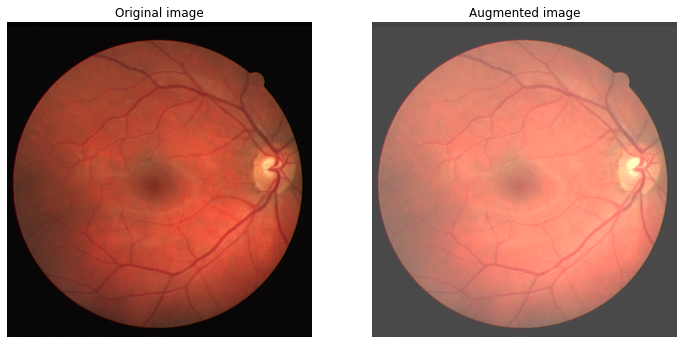

In [19]:
# convert augmented_images to numpy array
augmented_train_images_np = np.array(augmented_train_images)
rand_idx = np.random.randint(0, len(original_train_images))

# plot the original and augmented images
plt.figure(figsize=(12, 10))

plt.subplot(1, 2, 1)
plt.title("Original image")
plt.axis('off')
plt.imshow(original_train_images[rand_idx])

plt.subplot(1, 2, 2)
plt.title("Augmented image")
plt.axis('off')
plt.imshow(augmented_train_images_np[rand_idx])

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 32, 32, 3)


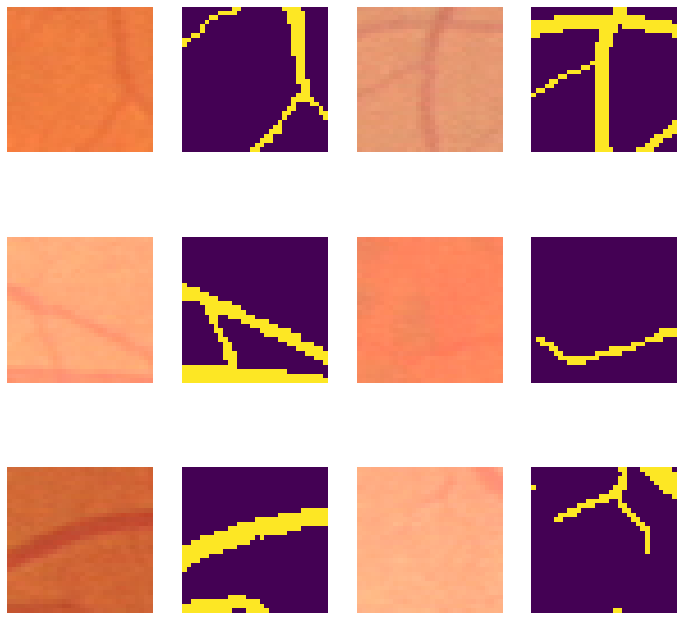

In [21]:
from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(augmented_train_images_np, 
                                                 train_segmentations, patch_size, 
                                                 patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [22]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(val_images, 
                                                         val_masks, 
                                                         val_segmentations, 
                                                         desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [24]:
# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 12
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model_brightness = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model_brightness.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model_brightness.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

(1, 584, 565, 3)
(1, 584, 565, 1)
Epoch 1/12
50/50 - 33s - loss: 0.5277 - acc: 0.8214 - val_loss: 0.3788 - val_acc: 0.9211
Epoch 2/12
50/50 - 27s - loss: 0.3111 - acc: 0.9494 - val_loss: 0.3109 - val_acc: 0.9211
Epoch 3/12
50/50 - 27s - loss: 0.2244 - acc: 0.9555 - val_loss: 0.2828 - val_acc: 0.9211
Epoch 4/12
50/50 - 27s - loss: 0.2216 - acc: 0.9546 - val_loss: 0.3957 - val_acc: 0.9081
Epoch 5/12
50/50 - 28s - loss: 0.1751 - acc: 0.9556 - val_loss: 0.4985 - val_acc: 0.9115
Epoch 6/12
50/50 - 27s - loss: 0.1481 - acc: 0.9596 - val_loss: 0.3313 - val_acc: 0.9164
Epoch 7/12
50/50 - 27s - loss: 0.1609 - acc: 0.9553 - val_loss: 0.3547 - val_acc: 0.9195
Epoch 8/12
50/50 - 27s - loss: 0.1285 - acc: 0.9601 - val_loss: 0.3238 - val_acc: 0.9235
Epoch 9/12
50/50 - 28s - loss: 0.1321 - acc: 0.9606 - val_loss: 0.2853 - val_acc: 0.9273
Epoch 10/12
50/50 - 27s - loss: 0.1338 - acc: 0.9598 - val_loss: 0.2109 - val_acc: 0.9380
Epoch 11/12
50/50 - 28s - loss: 0.1158 - acc: 0.9638 - val_loss: 0.2415 - v

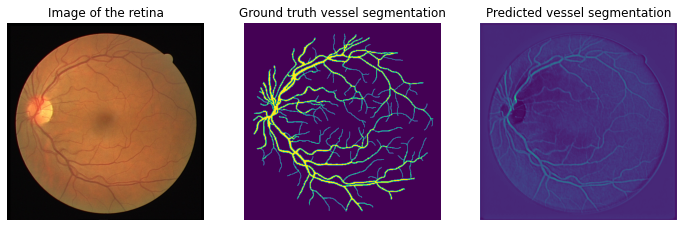

In [27]:
# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

### Compare the model with brightness augmentation and the baseline

In [30]:
# compute accuracy on the test set for original model and brightness model
test_accuracy_orig = unet_model_orig.evaluate(test_images, test_segmentations, verbose=0)
test_accuracy_brightness = model_brightness.evaluate(test_images, test_segmentations, verbose=0)

# accuracy
print("Original model accuracy on test set: {:.2f}%".format(test_accuracy_orig[1] * 100))
print("Brightness model accuracy on test set: {:.2f}%".format(test_accuracy_brightness[1] * 100))

# loss
print("Original model loss on test set: {:.2f}".format(test_accuracy_orig[0]))
print("Brightness model loss on test set: {:.2f}".format(test_accuracy_brightness[0]))

Original model accuracy on test set: 94.90%
Brightness model accuracy on test set: 93.75%
Original model loss on test set: 0.15
Brightness model loss on test set: 0.22


### Data augmentation b-spline

Data agumentation with random intensity and b-spline

In [ ]:
#trained model with random brightness
import tensorflow as tf
import gryds

random_images = np.empty([20,584,565,3])

for i in range(len(images)):
    random_images[i] = np.asarray((tf.image.random_brightness(images[i], 0.7)))

transformed_images = np.empty([20,584,565,3])
transformed_segmentations = np.empty([20,584,565,3])
#transformed_masks = np.empty([20,584,565,3])

for i in range(len(images)):
    random_grid = np.random.rand(2, 5, 5)
    random_grid -= 0.5
    random_grid /= 5
    
    bspline = gryds.BSplineTransformation(random_grid)
    bspline_images = gryds.MultiChannelInterpolator(random_images[i])
    transformed_images[i] = bspline_images.transform(bspline)
    
    #for transforming segmentations and masks too: creates error
    bspline_segmentation = gryds.MultiChannelInterpolator(segmentations[i])
    #bspline_masks = gryds.MultiChannelInterpolator(masks[i])
    transformed_segmentations[i] = bspline_segmentation.transform(bspline)
    #transformed_masks[i] = bspline_masks.transform(bspline)
    
plt.figure(figsize=(10, 8))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(transformed_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Transformed segmentation")
plt.axis('off')
plt.imshow(transformed_segmentations[0][:, :, 0])

plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    transformed_images, masks, segmentations, test_size=0.2, random_state=7)

#use for transformed segmentations and masks
#train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
#    transformed_images, transformed_masks, transformed_segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

In [ ]:
from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [ ]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

In [ ]:
# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 12
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

In [ ]:
# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()